На основе ТЕХНИЧЕСКОГО РЕГЛАМЕНТА ТАМОЖЕННОГО СОЮЗА "О БЕЗОПАСНОСТИ ЖЕЛЕЗНОДОРОЖНОГО ПОДВИЖНОГО СОСТАВА" сделайте нейро-консультанта, отвечающего на вопросы по документу.
Проработайте промпт самостоятельно. Нейро-консультант не должен отвечать на вопросы, не касающиеся документа (необходимо предусмотреть это в промпте).
Поэкспериментируйте со сплиттерами, найдите оптимальный вариант.
Сделайте нейро-консультанта, проверьте его работу на самостоятельно-сформулированных вопросах (достаточно 2-3)

Ссылка на регламент: https://docs.google.com/document/d/1YhUEX9fZDNTeE3eJ-yXskxZG46LsTRYvXjZ9Ij-t3Gw/edit?usp=sharing

In [1]:
!pip install -q faiss-cpu==1.8.0 tiktoken==0.7.0 langchain-core==0.2.33 langchain==0.2.14 langchain_community==0.2.12 sentence_transformers mistralai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.0/27.0 MB 24.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 36.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 391.5/391.5 kB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 997.8/997.8 kB 22.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 51.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260.0/260.0 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.8/311.8 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 1.7 MB/s eta 0:00:00


In [2]:
# запустите эту ячейку, если используете секретный ключ в колабе
import os
from mistralai import Mistral
from google.colab import userdata
api_key = userdata.get("MISTRAL_API_KEY")
os.environ["MISTRAL_API_KEY"] = api_key

# Создание клиента OpenAI с использованием API ключа из переменных среды
client = Mistral(api_key)

In [3]:
from sentence_transformers import SentenceTransformer
from langchain.text_splitter import CharacterTextSplitter
from langchain.vectorstores import FAISS
from langchain.text_splitter import RecursiveCharacterTextSplitter, MarkdownHeaderTextSplitter
import re
import requests
import openai
from langchain.docstore.document import Document
import tiktoken
import matplotlib.pyplot as plt

/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [4]:
# функция для загрузки документа по ссылке из гугл драйв
def load_document_text(url: str) -> str:
    # Extract the document ID from the URL
    match_ = re.search('/document/d/([a-zA-Z0-9-_]+)', url)
    if match_ is None:
        raise ValueError('Invalid Google Docs URL')
    doc_id = match_.group(1)

    # Download the document as plain text
    response = requests.get(f'https://docs.google.com/document/d/{doc_id}/export?format=txt')
    response.raise_for_status()
    text = response.text

    return text

In [5]:
# База знаний, которая будет подаваться в langChain
data_from_url= load_document_text('https://docs.google.com/document/d/1YhUEX9fZDNTeE3eJ-yXskxZG46LsTRYvXjZ9Ij-t3Gw/edit?usp=sharing') # заполните аргумент функции

In [6]:
data_from_url[:10000]

'\ufeffТЕХНИЧЕСКИЙ РЕГЛАМЕНТ\r\nТАМОЖЕННОГО СОЮЗА "О БЕЗОПАСНОСТИ ЖЕЛЕЗНОДОРОЖНОГО\r\nПОДВИЖНОГО СОСТАВА"\r\n \r\n(ТР ТС 001/2011)\r\n \r\n\r\n\r\n\t \r\nI. Область применения\r\n \r\n1. Настоящий технический регламент распространяется на вновь разрабатываемые (модернизируемые), изготавливаемые железнодорожный подвижной состав с конструкционной скоростью до 200 км/ч включительно и его составные части (далее - продукция), выпускаемые в обращение на таможенной территории Евразийского экономического союза (далее - Союз) для использования на железнодорожных путях общего и необщего пользования с шириной колеи 1 520 мм.\r\nЖелезнодорожный подвижной состав включает в себя:\r\nлокомотивы;\r\nмоторвагонный подвижной состав и его вагоны;\r\nпассажирские вагоны локомотивной тяги;\r\nгрузовые вагоны;\r\nспециальный железнодорожный подвижной состав.\r\nПеречень объектов технического регулирования, на которые распространяются требования настоящего технического регламента, приведен в приложении N 1.\

Предобрабатываем БЗ таким образом, чтобы можно было разметить ее в формате маркдаун разметки

In [7]:
def text_to_markdown(text):
    # Добавляем заголовок 1 уровня на основе римских чисел (без переноса строки)
    # и дублируем его строчкой ниже - иначе эта информация перенесется в метаданные, а порой она бывает полезной.
    def replace_header1(match):
        return f"# {match.group(2)}\n{match.group(2)}"

    text = re.sub(r'^(I{1,3}|IV|V|VI{1,3}|IX)\. (.+)', replace_header1, text, flags=re.M)

    # Добавляем текст, выделенный жирным шрифтом (он заключен между *)
    # и дублируем его строчкой ниже
    def replace_header2(match):
        return f"## {match.group(1)}\n{match.group(1)}"

    text = re.sub(r'\*([^\*]+)\*', replace_header2, text)

    return text

In [8]:
markdown = text_to_markdown(data_from_url)
print(markdown[:150000])

﻿ТЕХНИЧЕСКИЙ РЕГЛАМЕНТ
ТАМОЖЕННОГО СОЮЗА "О БЕЗОПАСНОСТИ ЖЕЛЕЗНОДОРОЖНОГО
ПОДВИЖНОГО СОСТАВА"
 
(ТР ТС 001/2011)
 


	 
# Область применения
Область применения
 
1. Настоящий технический регламент распространяется на вновь разрабатываемые (модернизируемые), изготавливаемые железнодорожный подвижной состав с конструкционной скоростью до 200 км/ч включительно и его составные части (далее - продукция), выпускаемые в обращение на таможенной территории Евразийского экономического союза (далее - Союз) для использования на железнодорожных путях общего и необщего пользования с шириной колеи 1 520 мм.
Железнодорожный подвижной состав включает в себя:
локомотивы;
моторвагонный подвижной состав и его вагоны;
пассажирские вагоны локомотивной тяги;
грузовые вагоны;
специальный железнодорожный подвижной состав.
Перечень объектов технического регулирования, на которые распространяются требования настоящего технического регламента, приведен в приложении N 1.
2. Настоящий технический регламент не распр

In [10]:
# Инструкция в system
system = load_document_text('https://docs.google.com/document/d/1GYaMlh4wD_NCez-8l5lV2o7yQM8H9Sai2sK-TxALYbE/edit?usp=sharing') # заполните аргумент функции ссылкой на составленный вами промпт. Не забудьте открыть доступ

In [11]:
print(system[:1000])

﻿Ты консультант по регламенту ТАМОЖЕННОГО СОЮЗА "О БЕЗОПАСНОСТИ ЖЕЛЕЗНОДОРОЖНОГО ПОДВИЖНОГО СОСТАВА”. Ответь на вопрос клиента, основываясь исключительно на предоставленной информации. Не добавляй никаких личных мнений или интерпретаций, отвечай максимально точно и подробно на основе содержимого. Не упоминай о наличии документа или источника информации. Клиент не должен знать о существовании документа, на основе которого ты формируешь ответ. Убедись, что все ответы ясны, логичны и соответствуют действующим нормам и правилам в области экологической экспертизы.


In [12]:
def num_tokens_from_string(string: str, encoding_name: str) -> int:
      """Возвращает количество токенов в строке"""
      encoding = tiktoken.get_encoding(encoding_name)
      num_tokens = len(encoding.encode(string))
      return num_tokens

def split_text(text, max_count):
    headers_to_split_on = [
        ("#", "Header 1"),
        ("##", "Header 2"),
    ]

    markdown_splitter = MarkdownHeaderTextSplitter(headers_to_split_on=headers_to_split_on)
    fragments = markdown_splitter.split_text(text)

    # Подсчет токенов для каждого фрагмента и построение графика
    fragment_token_counts = [num_tokens_from_string(fragment.page_content, "cl100k_base") for fragment in fragments]
    plt.hist(fragment_token_counts, bins=50, alpha=0.5, label='Fragments')
    plt.title('Distribution of Fragment Token Counts')
    plt.xlabel('Token Count')
    plt.ylabel('Frequency')
    plt.show()

    splitter = RecursiveCharacterTextSplitter(
        chunk_size=max_count,
        chunk_overlap=0,
        length_function=lambda x: num_tokens_from_string(x, "cl100k_base")
    )

    source_chunks = [
        Document(page_content=chunk, metadata=fragment.metadata)
        for fragment in fragments
        for chunk in splitter.split_text(fragment.page_content)
    ]

    # Подсчет токенов для каждого source_chunk и построение графика
    source_chunk_token_counts = [num_tokens_from_string(chunk.page_content, "cl100k_base") for chunk in source_chunks]
    plt.hist(source_chunk_token_counts, bins=20, alpha=0.5, label='Source Chunks')
    plt.title('Distribution of Source Chunk Token Counts')
    plt.xlabel('Token Count')
    plt.ylabel('Frequency')
    plt.show()

    return source_chunks, fragments

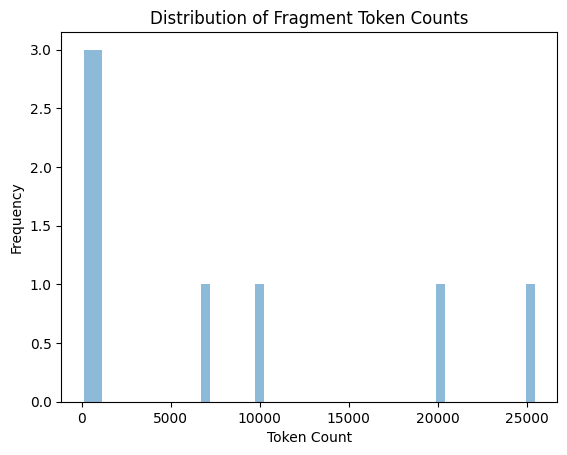

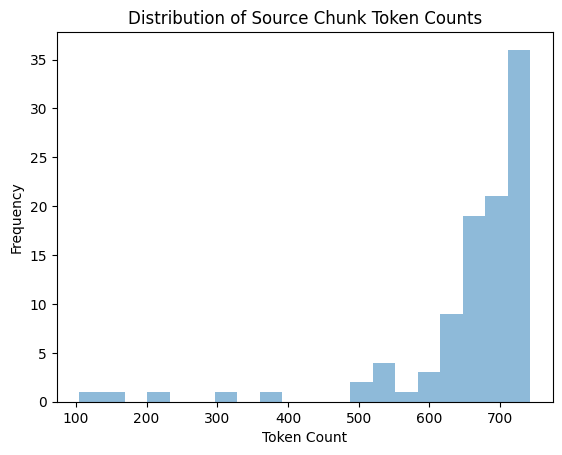

Общее количество чанков:  100
Первый чанк  page_content='ТЕХНИЧЕСКИЙ РЕГЛАМЕНТ
ТАМОЖЕННОГО СОЮЗА "О БЕЗОПАСНОСТИ ЖЕЛЕЗНОДОРОЖНОГО
ПОДВИЖНОГО СОСТАВА"  
(ТР ТС 001/2011)'


In [13]:
source_chunks, fragments = split_text(markdown, 750)
print("Общее количество чанков: ",len(source_chunks))
print("Первый чанк ", source_chunks[0])

In [14]:
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')
# Функция для создания эмбеддингов из массива документов
def create_embeddings(documents):
    page_contents = [doc.page_content for doc in documents]
    return model.encode(page_contents)

# Создание эмбеддингов
embeddings = create_embeddings(fragments)

# Создадим индексную базу из разделенных фрагментов текста
import numpy as np
import faiss
# Преобразование эмбеддингов в массив numpy
embeddings = np.array(embeddings).astype('float32')

# Создание индекса FAISS
dimension = embeddings.shape[1]  # Размерность векторов
db = faiss.IndexFlatL2(dimension)  # Использование L2 метрики

# Добавление векторов в индекс
db.add(embeddings)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.73k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [17]:
def answer_index(system, topic, query_vector, source_chunks, search_index, verbose=1):

    # Поиск релевантных отрезков из базы знаний
    distances, indices =  search_index.search(query_vector, k=4)
    #indices_list = indices[0].tolist()
    # Вывод ближайших документов
    docs = [source_chunks[i] for i in indices[0]]
    if verbose: print('\n ===========================================: ')
    message_content = re.sub(r'\n{2}', ' ', '\n '.join([f'\nОтрывок документа №{i+1}\n=====================' + doc.page_content + '\n' for i, doc in enumerate(docs)]))
    if verbose: print('message_content :\n ======================================== \n', message_content)
    client = Mistral(api_key=api_key)
    messages = [
        {"role": "system", "content": system},
        {"role": "user", "content": f"Ответь на вопрос. Документ с информацией для ответа: {message_content}\n\nВопрос пользователя: \n{topic}"}
    ]

    if verbose: print('\n ===========================================: ')

    completion = client.chat.complete(
        model="mistral-small-latest",             # выберите модель самостоятельно
        messages=messages,
        temperature=0          # укажите значение
    )
    answer = completion.choices[0].message.content
    return answer  # возвращает ответ

Проверьте работу нейро-консультанта на сформулированных вами вопросах (достаточно 1-2)

In [18]:
# вопрос пользователя
topic= "Какие требования безопасности должны быть соблюдены при проектировании железнодорожного подвижного состава?"                                         # Напишите сюда вопрос нейро-консультанту
query_vector = model.encode([topic])
query_vector = np.array(query_vector).astype('float32')

ans = answer_index(system, topic, query_vector, source_chunks, db)
ans


 ===========================================: 
message_content :
 
Отрывок документа №1
====================="железнодорожные пути необщего пользования" - железнодорожные подъездные пути, примыкающие непосредственно или через другие железнодорожные подъездные пути к железнодорожным путям общего пользования и предназначенные для оказания определенным пользователям услуг железнодорожного транспорта на условиях договоров или выполнения работ для собственных нужд;
"железнодорожные пути общего пользования" - железнодорожные пути на территориях железнодорожных станций, открытых для выполнения операций по приему и отправлению поездов, по приему и выдаче грузов, багажа и грузобагажа, по обслуживанию пассажиров и выполнению сортировочной и маневровой работы, а также железнодорожные пути, соединяющие такие станции;
"изотермические вагоны" - крытые вагоны с термоизоляцией, предназначенные для перевозки грузов, требующих поддержания в определенном диапазоне температуры в течение времени их достав

'При проектировании железнодорожного подвижного состава должны быть соблюдены следующие требования безопасности:\n\n1. **Механическая безопасность**: Обеспечение отсутствия возможности возникновения опасных механических воздействий.\n2. **Конструкторская документация**: Совокупность конструкторских документов, содержащих данные, необходимые для проектирования, изготовления, контроля, приемки, поставки, эксплуатации, ремонта, модернизации и утилизации изделия.\n3. **Конструкционная скорость**: Наибольшая скорость движения железнодорожного подвижного состава, заявленная в технической документации.\n4. **Составная часть железнодорожного подвижного состава**: Деталь, сборочная единица, комплекс или их комплект, программные средства, входящие в конструкцию железнодорожного подвижного состава и обеспечивающие его безопасную эксплуатацию, безопасность обслуживающего персонала и (или) пассажиров.\n5. **Руководство по эксплуатации**: Документ, содержащий сведения о конструкции, принципе действи

In [19]:
# вопрос пользователя
topic= "Какие устройства должны быть установлены на грузовых локомотивах, предназначенных для работы на участках с интенсивным движением?"                                         # Напишите сюда вопрос нейро-консультанту
query_vector = model.encode([topic])
query_vector = np.array(query_vector).astype('float32')

ans = answer_index(system, topic, query_vector, source_chunks, db)
ans


 ===========================================: 
message_content :
 
Отрывок документа №1
====================="железнодорожные пути необщего пользования" - железнодорожные подъездные пути, примыкающие непосредственно или через другие железнодорожные подъездные пути к железнодорожным путям общего пользования и предназначенные для оказания определенным пользователям услуг железнодорожного транспорта на условиях договоров или выполнения работ для собственных нужд;
"железнодорожные пути общего пользования" - железнодорожные пути на территориях железнодорожных станций, открытых для выполнения операций по приему и отправлению поездов, по приему и выдаче грузов, багажа и грузобагажа, по обслуживанию пассажиров и выполнению сортировочной и маневровой работы, а также железнодорожные пути, соединяющие такие станции;
"изотермические вагоны" - крытые вагоны с термоизоляцией, предназначенные для перевозки грузов, требующих поддержания в определенном диапазоне температуры в течение времени их достав

'На грузовых локомотивах, предназначенных для работы на участках с интенсивным движением, должны быть установлены устройства, обеспечивающие их безопасную эксплуатацию и соответствие требованиям технического регламента. В частности, это могут быть системы рекуперативного торможения, которые позволяют эффективно тормозить локомотив и передавать высвобождаемую электрическую энергию обратно в контактную сеть. Также необходимы системы пневматического торможения для обеспечения надежного торможения поезда. Важно, чтобы все устройства соответствовали требованиям конструкторской документации и были описаны в руководстве по эксплуатации для обеспечения правильной и безопасной эксплуатации локомотива.'

In [20]:
# вопрос пользователя
topic= "Какое оборудование должно быть установлено на вагонах-цистернах для обеспечения безопасности при работе с грузами?"                                         # Напишите сюда вопрос нейро-консультанту
query_vector = model.encode([topic])
query_vector = np.array(query_vector).astype('float32')

ans = answer_index(system, topic, query_vector, source_chunks, db)
ans


 ===========================================: 
message_content :
 
Отрывок документа №1
====================="железнодорожные пути необщего пользования" - железнодорожные подъездные пути, примыкающие непосредственно или через другие железнодорожные подъездные пути к железнодорожным путям общего пользования и предназначенные для оказания определенным пользователям услуг железнодорожного транспорта на условиях договоров или выполнения работ для собственных нужд;
"железнодорожные пути общего пользования" - железнодорожные пути на территориях железнодорожных станций, открытых для выполнения операций по приему и отправлению поездов, по приему и выдаче грузов, багажа и грузобагажа, по обслуживанию пассажиров и выполнению сортировочной и маневровой работы, а также железнодорожные пути, соединяющие такие станции;
"изотермические вагоны" - крытые вагоны с термоизоляцией, предназначенные для перевозки грузов, требующих поддержания в определенном диапазоне температуры в течение времени их достав

'Для обеспечения безопасности при работе с грузами на вагонах-цистернах должны быть установлены следующие элементы:\n\n1. **Кран экстренного торможения (стоп-кран)**: Этот кран служит для выпуска воздуха из тормозной магистрали железнодорожного подвижного состава и приведения в действие автоматических тормозов в случае необходимости экстренной остановки.\n\n2. **Магниторельсовый тормоз**: Это устройство создает тормозное усилие путем электромагнитного притяжения тормозного башмака к рельсу, что способствует безопасной остановке поезда.\n\n3. **Машинное помещение**: В этом помещении установлены энергетическая установка (основная и (или) вспомогательная) и вспомогательное оборудование, обеспечивающее функционирование вагона и предусматривающее нахождение в нем обслуживающего персонала.\n\nЭти элементы обеспечивают механическую безопасность железнодорожного подвижного состава, предотвращая возникновение опасных механических воздействий и обеспечивая надежную остановку поезда в случае необ